In [1]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

In [2]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('california_housing')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

origin.head()

[data] https://data.hossam.kr/data/kaggle/california_housing.xlsx
[desc] 1990년 미국 인구조사(Census)를 기반으로 캘리포니아 각 지역의 인구·주택·소득 특성과 주택 중위가격을 담아, 회귀 분석과 머신러닝 모델 실습에 널리 사용되는 대표적인 주택 가격 데이터 (출처: https://www.kaggle.com/datasets/camnugent/california-housing-prices)

field               description
------------------  ------------------------------------------------------------------------------
longitude           경도(Longitude). 서경(–값) 기준.
latitude            위도(Latitude). 북위(+) 기준.
housing_median_age  해당 구역(블록 그룹)의 주택 중위 연령(년).
total_rooms         구역 내 모든 주택의 총 방(room) 수 합계.
total_bedrooms      구역 내 모든 주택의 총 침실(bedroom) 수 합계.
population          구역의 전체 인구 수.
households          구역의 전체 “가구 수”(living units).
median_income       구역의 중위 소득(median income), 단위는 약 1 = $10,000 수준.
median_house_value  주택 중위가격(달러). 회귀의 목표변수(타깃).
ocean_proximity     해안과의 거리/접근성 범주: <1H OCEAN, INLAND, NEAR BAY, NEAR OCEAN, ISLAND 등.


===== 데이터 크기 확인 =====
데이터셋 크기 : (20640, 10)
열 개수: 10
행 개수: 20640


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


In [4]:
print("\n===== 데이터 타입 확인 =====")
print(origin.info())


===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB
None


### 미션 1. 이 데이터의 신뢰성
- 1. 결측치, 이상치, 편향 점검 - 처리 기준 제시
- 2. 주요 변수의 범위가 현실적인지 판단
- 3. 특정 변수의 데이터 확인 및 영향 검토(housing_median_age의 값이 52인 값들)
- 4. 전처리 전,후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약

In [5]:
# 1. 결측치, 이상치, 편향 점검 - 처리 기준 제시
print("\n===== 결측치 확인 =====")
print(origin.isnull().sum())


===== 결측치 확인 =====
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


- total_roooms 속에 bedroom이 속해 있다고 판단하여 결측치를 비율로 대체하기로 결정
- 결측치 처리 기준 : null값이 아닌 다른 컬럼들의 total_rooms 대비 total_bedrooms의 개수를 비율로 계산한 뒤 total_bedrooms가 null인 컬럼에 total_rooms * 비율 로 대체

In [6]:
df = origin.copy()
# 1. 평균 침실 비율 계산 - 전체 침실 수 / 전체 가구 수
bedroom_ratio = (df['total_bedrooms'] / df['total_rooms']).mean()
print(f"캘리포니아 주택의 평균 침실 비율: {bedroom_ratio:.4f}")

# 2. total_rooms에 속해있는 bedrooms들을 이용하여 전체 방 평균 비율을 곱해 침실 개수를 정함
df['total_bedrooms'] = df['total_rooms'].fillna(df['total_rooms'] * bedroom_ratio)

print(f"결측치 처리 후 남은 개수 : {df['total_bedrooms'].isnull().sum()}")
print(f"전체 데이터 건수 유지 : {len(df)}건")

캘리포니아 주택의 평균 침실 비율: 0.2130
결측치 처리 후 남은 개수 : 0
전체 데이터 건수 유지 : 20640건


In [7]:
# - 2. 주요 변수의 범위가 현실적인지 판단
print("\n===== 주요 변수의 기초 통계량 확인 =====")
df.describe()


===== 주요 변수의 기초 통계량 확인 =====


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,2635.763081,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,2181.615252,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,1447.750000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,2127.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,3148.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,39320.000000,35682.000000,6082.000000,15.000100,500001.000000


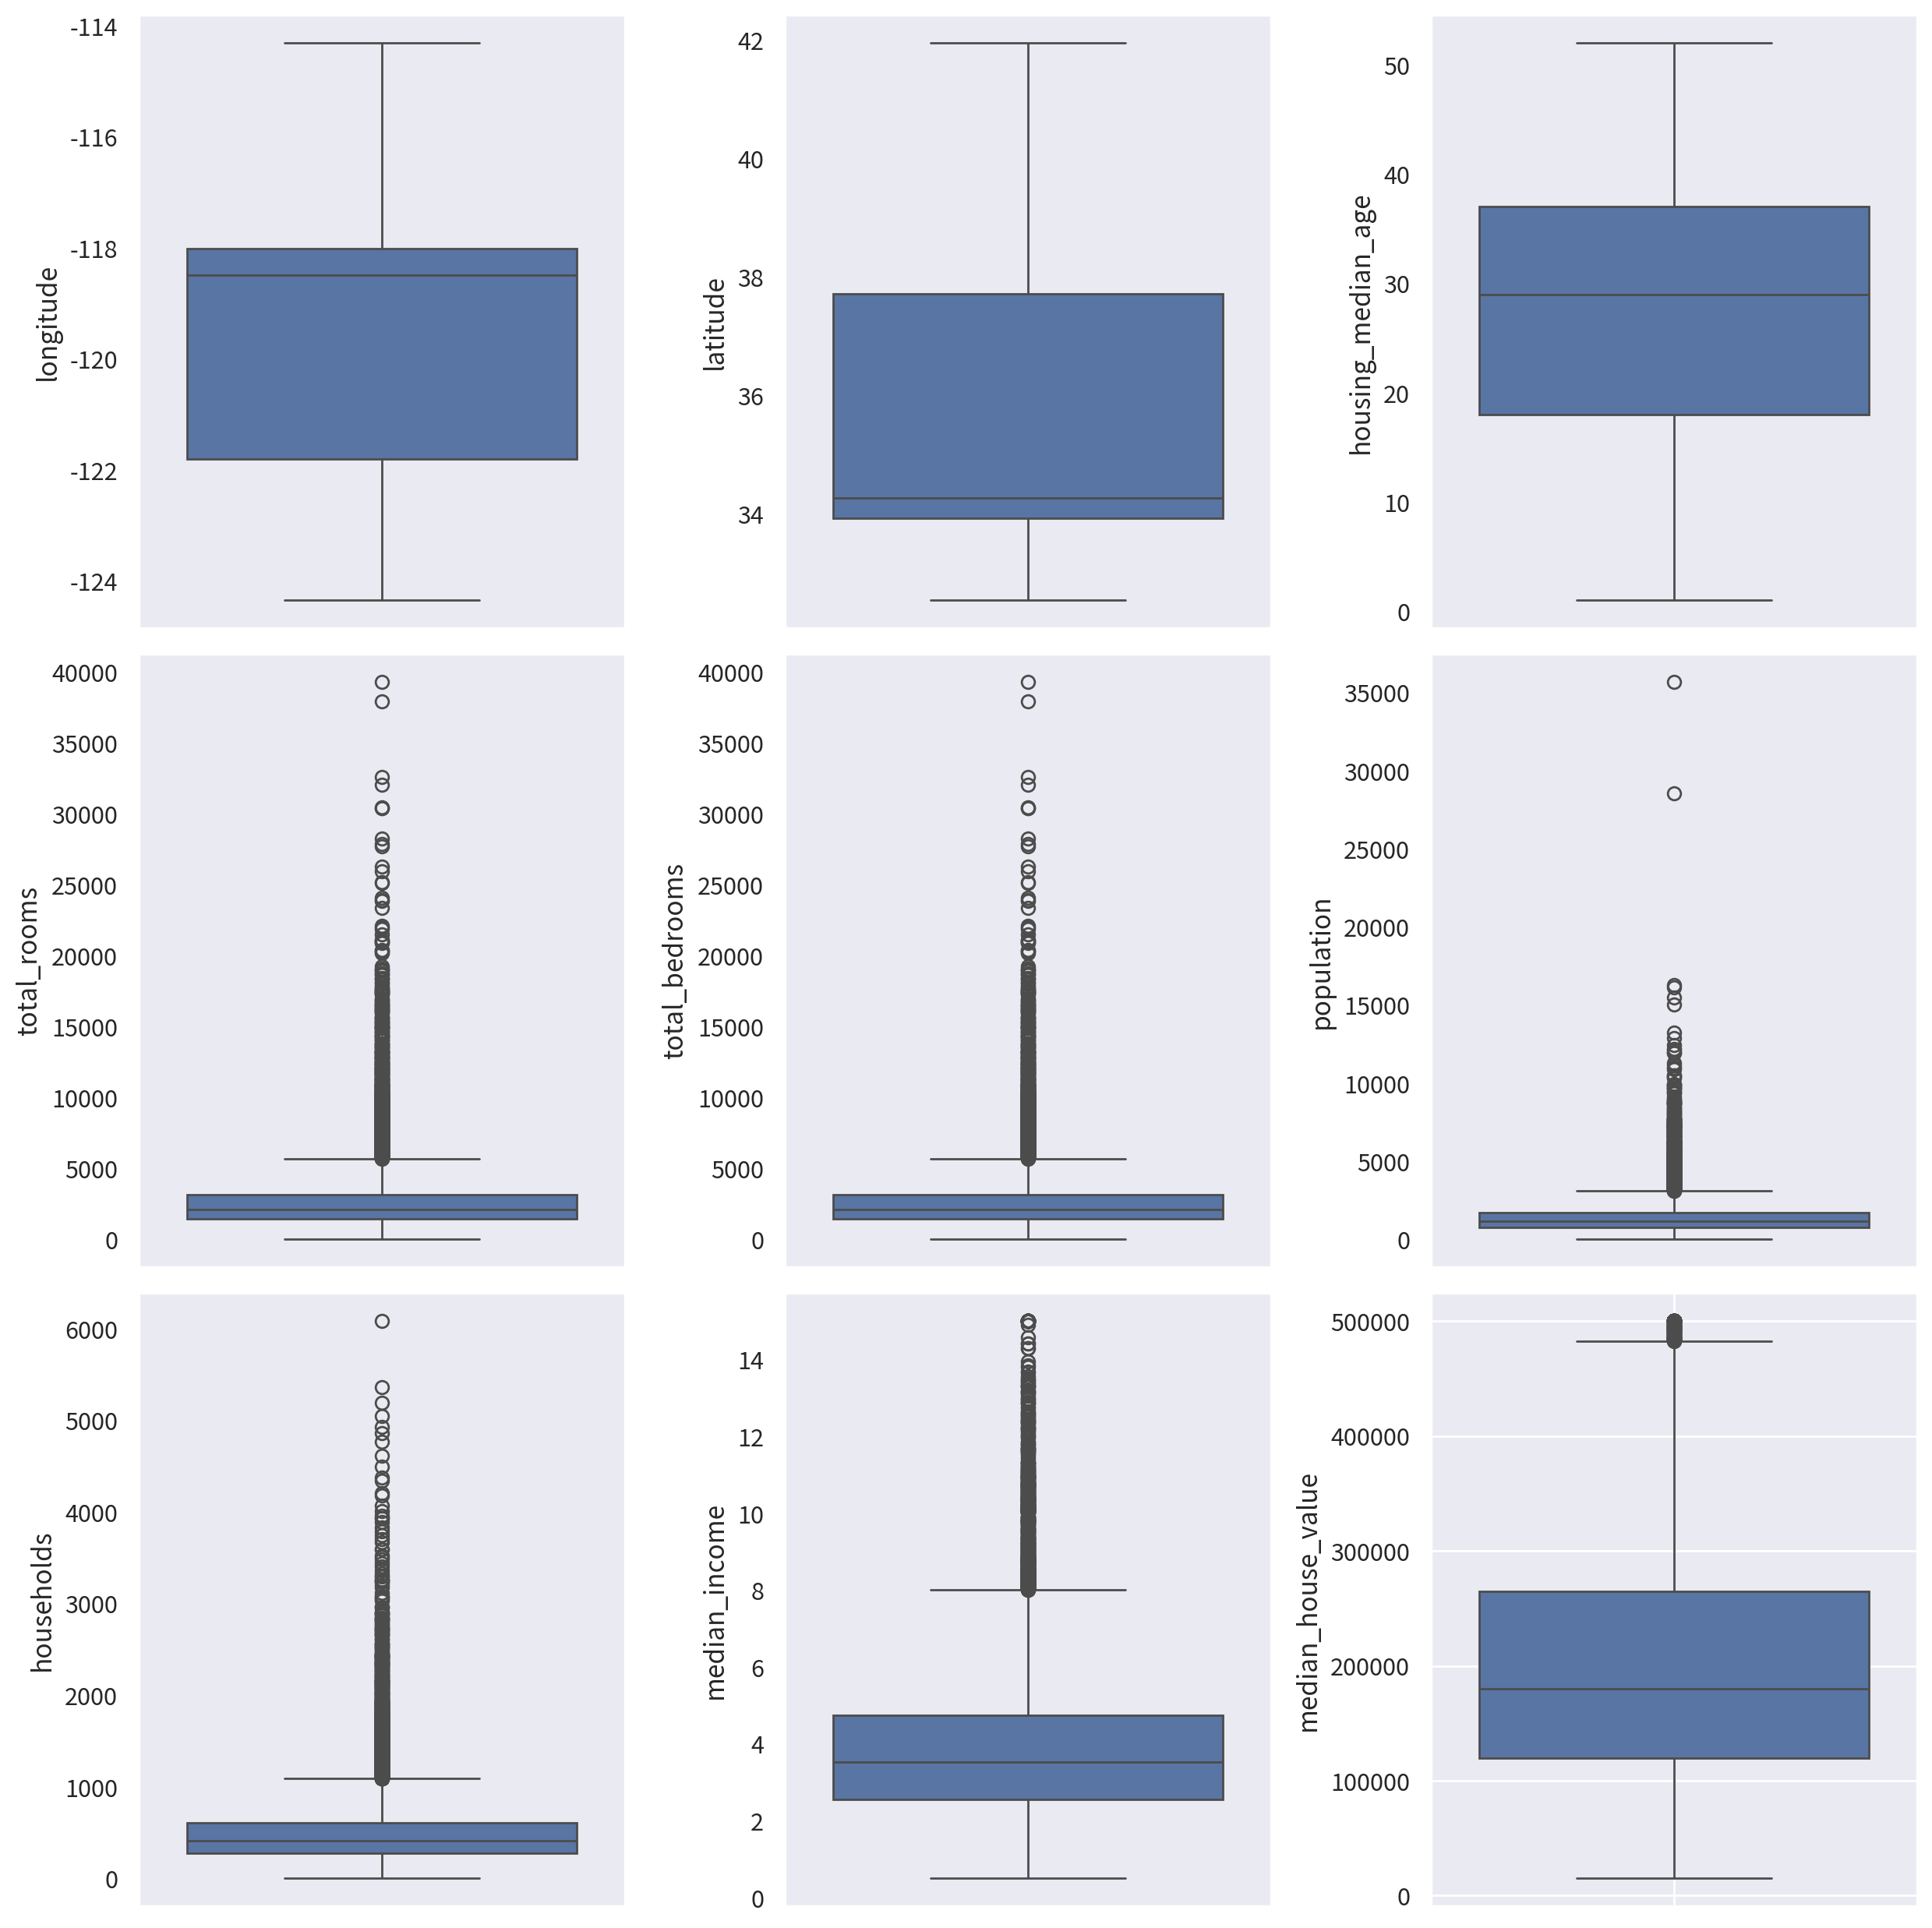

In [8]:
# 이상치를 알기 위해 박스플롯 시각화
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df['longitude'],orient='v',ax=ax[0][0])
sb.boxplot(data=df['latitude'],orient='v',ax=ax[0][1])
sb.boxplot(data=df['housing_median_age'],orient='v',ax=ax[0][2])
sb.boxplot(data=df['total_rooms'],orient='v',ax=ax[1][0])
sb.boxplot(data=df['total_bedrooms'],orient='v',ax=ax[1][1])
sb.boxplot(data=df['population'],orient='v',ax=ax[1][2])
sb.boxplot(data=df['households'],orient='v',ax=ax[2][0])
sb.boxplot(data=df['median_income'],orient='v',ax=ax[2][1])
sb.boxplot(data=df['median_house_value'],orient='v',ax=ax[2][2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 위도와 경도, 집의 나이 중위 수를 제외한 모든 컬럼에 이상치가 존재함
    - 이상치지만 틀린 데이터가 아니라 현실성에 가까운 데이터
    - 해당 데이터는 지역(블록 그룹)이라는 특성을 가진 데이터이기 때문에 규모가 클 수 있음.
        - 인구값이 5000이라면 방이 1만개인것은 이론상 가능한 수치라고 생각
    - 1940년 이전 주택이 52로 코딩되는 것은 상한선을 정해둔듯 함. median_house_value 같은 경우도 최댓값이 500,001로 되어있는 것을 보아 50만 달러가 넘어가는 데이터는 50.1만 달러로 상한선을 정해둠
        - 상한선이 정해져있기 때문에 50만 달러가 넘는 값을 예측하게 되면 성능이 떨어질 수 있음.
        - 상한선을 넘는 값을 예측하기 위해서는 추가적인 데이터가 필요함

In [ ]:
#- 3. 특정 변수의 데이터 확인 및 영향 검토(housing_median_age의 값이 52인 값들)
# 상한선에 해당하는 데이터의 개수를 파악하기
print(df['median_house_value'].count())
print(df[df['median_house_value'] > 500000]['median_house_value'].count())
print(f"상한선 초과 데이터 비율: {df[df['median_house_value'] > 500000]['median_house_value'].count() / df['median_house_value'].count() * 100:.2f}%")

print(df['housing_median_age'].count())
print(df[df['housing_median_age'] == 52]['housing_median_age'].count())
print(f"상한선 초과 데이터 비율: {df[df['housing_median_age'] == 52]['housing_median_age'].count() / df['housing_median_age'].count() * 100:.2f}%")

20640
965
상한선 초과 데이터 비율: 4.68%
20640
1273
상한선 초과 데이터 비율: 6.17%


- median_house_value 와 housing_median_age 값의 상한선처럼 걸려있는 값들이 분석에 영향을 줄 수 있다고 판단 -> 소득이 올라가도 집 값은 안올라간다고 착각할 수 있고, 실제로 50만 달러가 아닌 집임에도 50만 달러를 학습시키는 것과 같은 효과
    - 분석 목적인 캘리포니아의 주거 시장을 이해하기 위해 상한선 값을 제거한 데이터를 가지고 분석 진행

In [12]:
# 상한선 제거 데이터 프레임은 df_cleaned 로 저장
# 상한선 제거 하지 않은 데이터 프레임은 df 로 저장
# 추후 두 데이터를 가지고 비교 분석 진행
df_cleaned = df[(df['median_house_value'] <= 500000) & (df['housing_median_age'] < 52)]
print(f"상한선 제거 전 데이터셋 크기 : {df.shape}")
print(f"상한선 제거 후 데이터셋 크기 : {df_cleaned.shape}")
print(f"제거된 데이터 비율: {(df.shape[0] - df_cleaned.shape[0]) / df.shape[0] * 100:.2f}%")


상한선 제거 전 데이터셋 크기 : (20640, 10)
상한선 제거 후 데이터셋 크기 : (18572, 10)
제거된 데이터 비율: 10.02%


- 데이터의 10%에 해당하는 값을 지운 만큼 비교 분석을 필요할듯.
    - 고가의 주택 가격을 예측할 때는 상한선 제거로 학습한 모델이 성능이 더 좋을것이라 예상하고 전처리 진행
- 4. 전처리 전,후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약

In [18]:
print("전처리 전 데이터셋 기술통계량 \n")
df.describe()

전처리 전 데이터셋 기술통계량 



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,2635.763081,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,2181.615252,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,1447.750000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,2127.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,3148.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,39320.000000,35682.000000,6082.000000,15.000100,500001.000000


In [19]:
print("전처리 후 데이터셋 기술통계량 \n")
df_cleaned.describe()

전처리 후 데이터셋 기술통계량 



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000
mean,-119.484929,35.593231,26.983847,2668.840997,2668.840997,1470.392957,508.721355,3.693262,189607.608066
std,1.980865,2.147712,11.431815,2223.829793,2223.829793,1162.944307,389.567263,1.570045,95790.237279
min,-124.300000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.550000,33.920000,17.000000,1454.750000,1454.750000,811.000000,284.000000,2.537275,115400.000000
50%,-118.450000,34.240000,27.000000,2142.000000,2142.000000,1203.000000,416.000000,3.468350,171200.000000
75%,-117.970000,37.670000,36.000000,3184.000000,3184.000000,1781.000000,614.000000,4.616100,243225.000000
max,-114.310000,41.950000,51.000000,39320.000000,39320.000000,35682.000000,6082.000000,15.000100,500000.000000


- 총 데이터 건 수 20640 -> 18572 (약 10% 삭제)
- 결측치 = 0 (total_bedrooms의 결측치를 total_rooms와의 비율로 대체)
- 이상치 처리 = 상한선이라고 판단되는 값(500,001 | 52)들 삭제 진행
    - 일반적인 캘리포니아의 주거 시장을 알아보기 위해서 삭제

### 미션 2. 가격과 핵심 변수의 첫 인상
- 1. median_house_value, median_income, housing_median_age, total_rooms 분포를 히스토그램/KDE로 확인 및 객관적 사실 서술
- 2. 왜도/이상치가 회귀에 줄 수 있는 영향과 변환할 필요가 있는지 서술
- 3. 분포 비교는 동일 축 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약
- 4. 지역별(Latitude/Longitude) 편향이나 시계열 문제(1990년 데이터만)가 해석에 미치는 영향도 짧게 언급

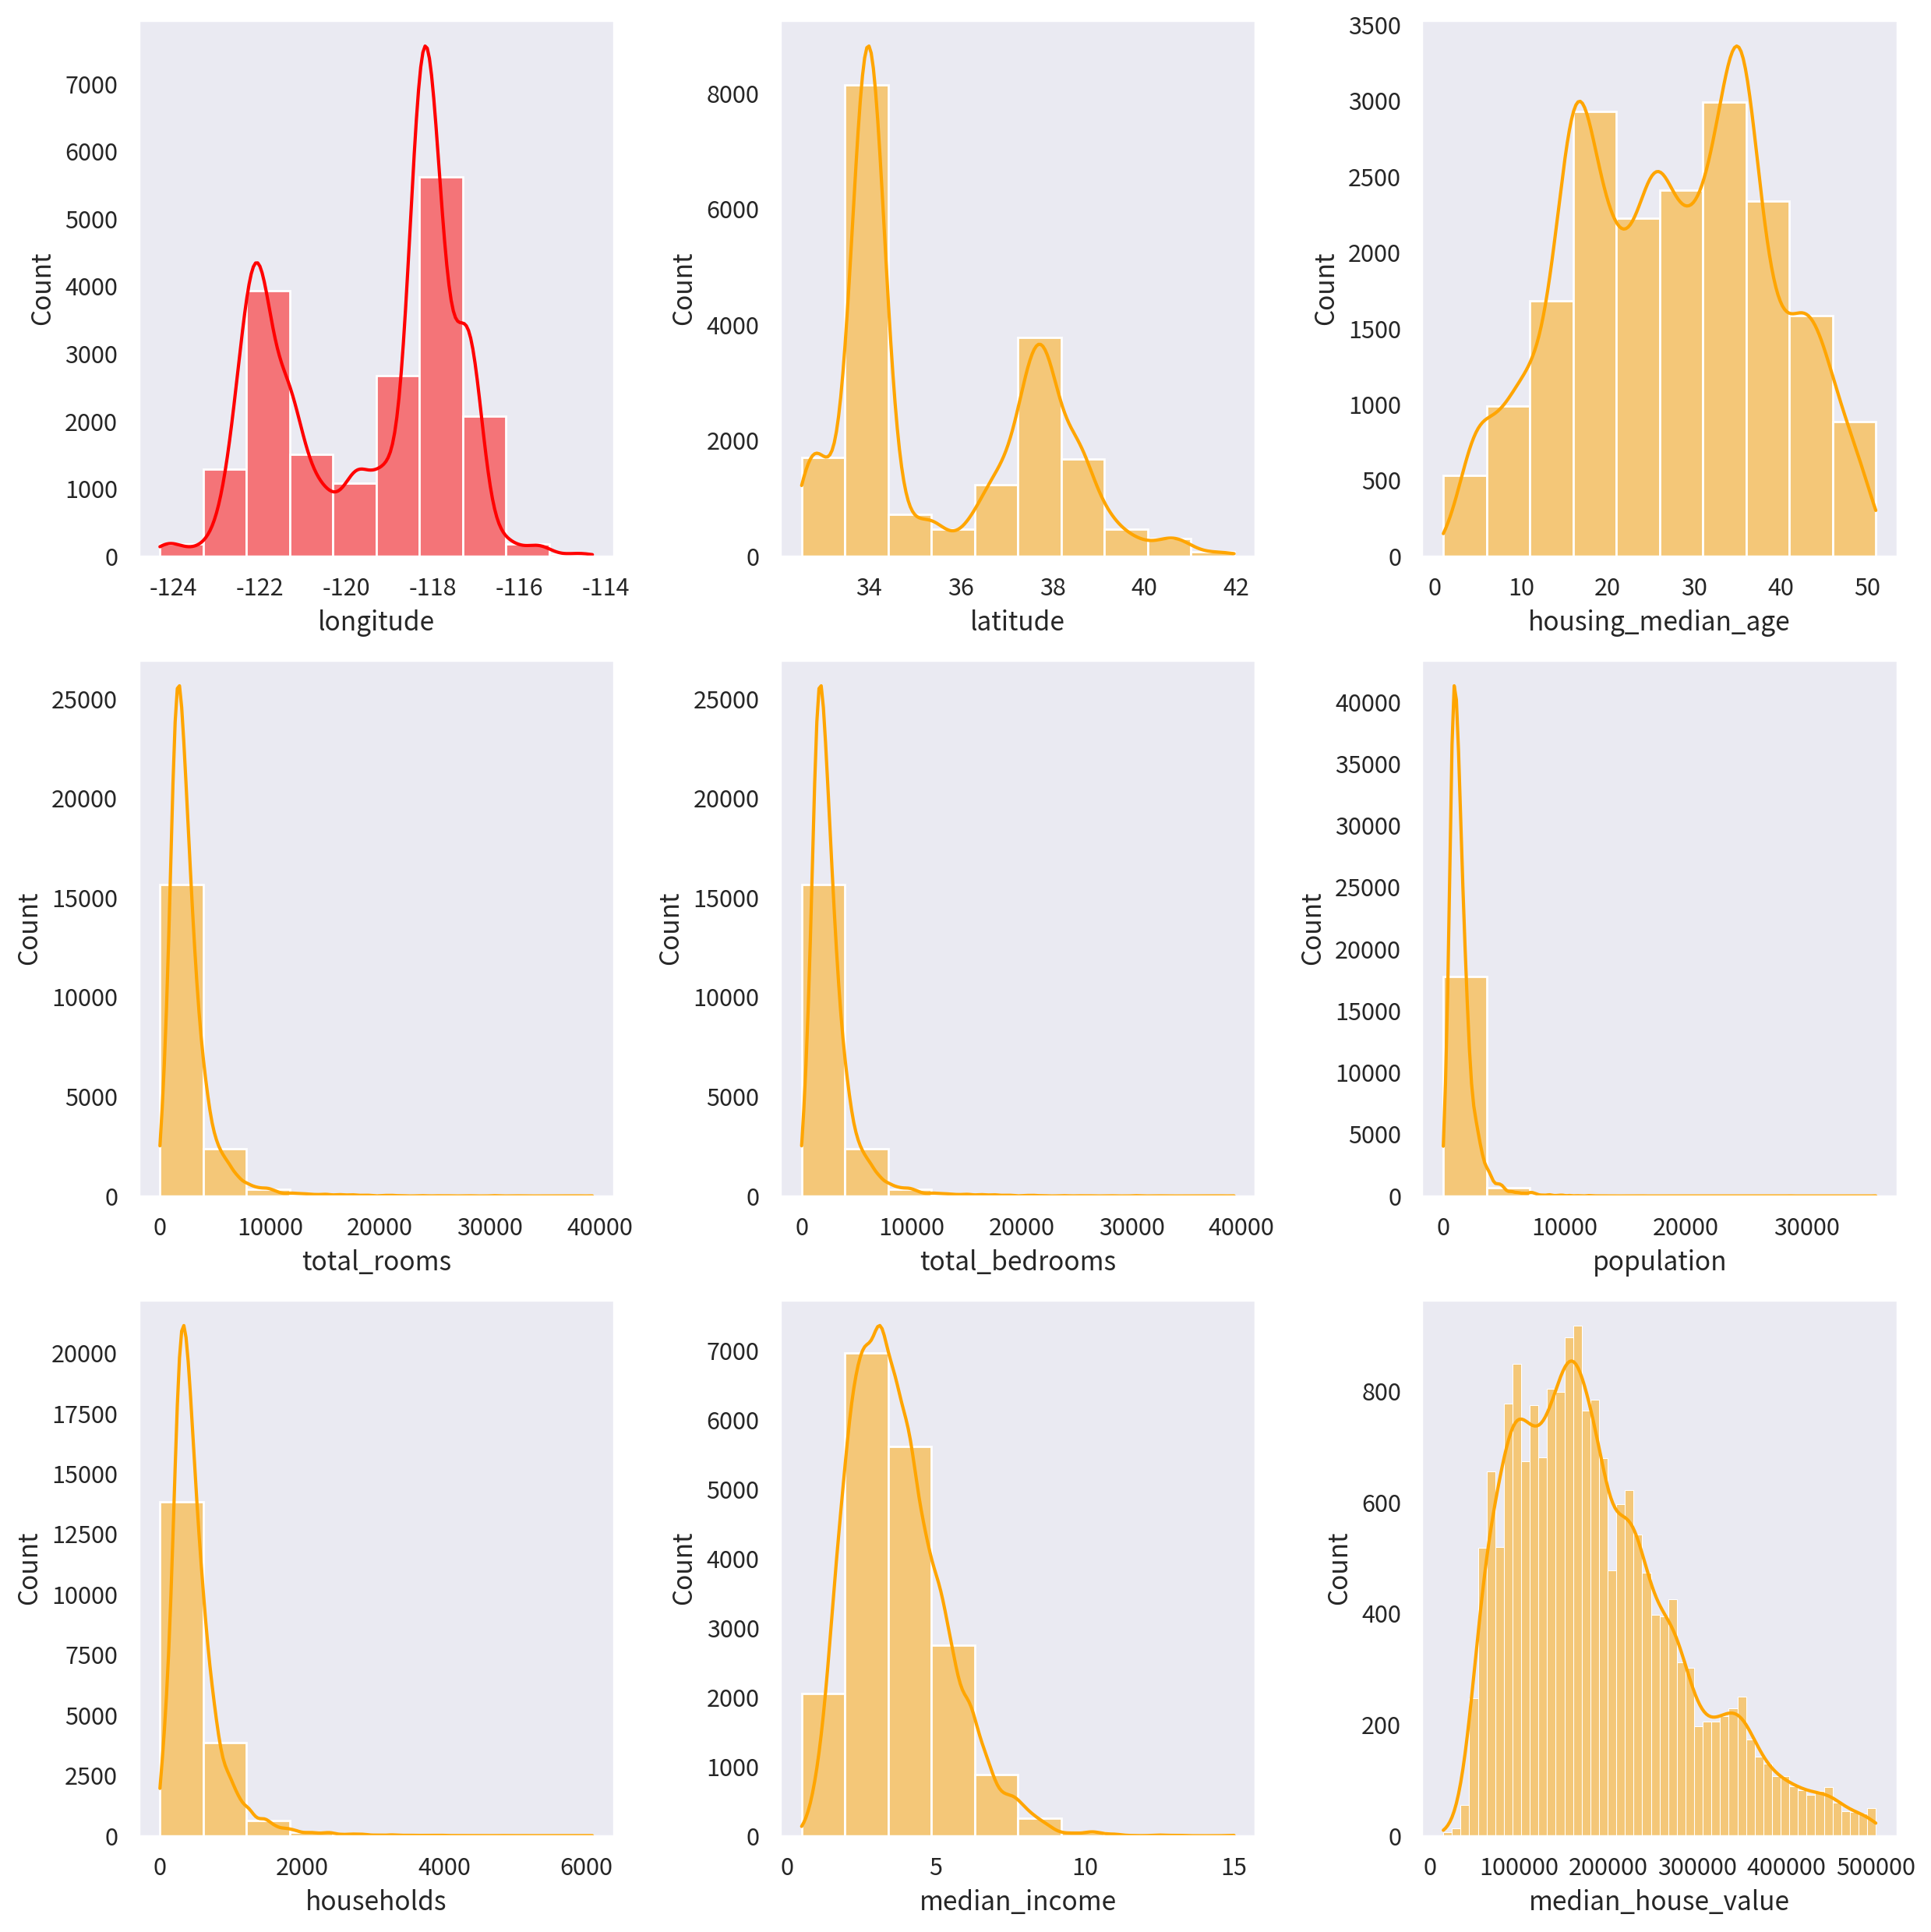

In [20]:
#1. median_house_value, median_income, housing_median_age, total_rooms 분포를 히스토그램/KDE로 확인 및 객관적 사실 서술
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df_cleaned, x='longitude', bins=10, kde=True, color='red', ax=ax[0,0])
sb.histplot(data=df_cleaned, x='latitude', bins=10, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df_cleaned, x='housing_median_age', bins=10, kde=True, color='orange', ax=ax[0,2])
sb.histplot(data=df_cleaned, x='total_rooms', bins=10, kde=True, color='orange', ax=ax[1,0])
sb.histplot(data=df_cleaned, x='total_bedrooms', bins=10, kde=True, color='orange', ax=ax[1,1])
sb.histplot(data=df_cleaned, x='population', bins=10, kde=True, color='orange',ax=ax[1,2])
sb.histplot(data=df_cleaned, x='households', bins=10, kde=True, color='orange',ax=ax[2,0])
sb.histplot(data=df_cleaned, x='median_income', bins=10, kde=True, color='orange',ax=ax[2,1])
sb.histplot(data=df_cleaned, x='median_house_value', bins=50, kde=True, color='orange',ax=ax[2,2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 객관적 사실 서술
    - housing_median_age의 경우 상한선 값을 삭제하면서 비교적 고루게 분포해있는 모습을 알 수 있음
    - total_rooms, total_bedrooms, population,households의 경우 우편향이 매우 심함, 비율로 변환하기 위해 로그 변환 적용이 필요해보임
        - 왼쪽을 기준으로 최빈값-중앙값-평균순으로 나타나며 오른쪽으로 꼬리가 나있음
    - median_income의 경우 대부분의 데이터가 2~6 구간에 집중되어 있고, 우편향이 존재함
        - 소득의 불균형이 존재한다고 볼 수 있음
        - 우편향을 해소하기 위해 로그 변환 고려
        - 왼쪽을 기준으로 최빈값-중앙값-평균순으로 나타나며 오른쪽으로 꼬리가 나있음
    - median_house_value의 경우 상한선 값을 삭제하였지만 우편향을 보임
        - 로그 변환 고려
        - 왼쪽을 기준으로 최빈값-중앙값-평균순으로 나타나며 오른쪽으로 꼬리가 나있음
            - 명목형 변수 처리할 때 ISLAND 값이 5개 밖에 없는데 다 고소득 가구라서 빼고 진행해보기(일반적인 캘리포니아의 주택 시장 데이터라는 것의 일관성을 갖기 위해)
- 4. 지역별(Latitude/Longitude) 편향이나 시계열 문제(1990년 데이터만)가 해석에 미치는 영향도 짧게 언급
    - 데이터를 산점도로 찍어보면 알 수 있듯이 LA와 샌프란시스코 등 대도시권에 밀집되어있음
        - 모델이 대도시의 가격 결정을 진행할때는 매우 잘할 수 있지만, 외곽 지역, 데이터가 모자란 지역은 제대로 반영하지 못할 수 있음
    - 1990년 인구조사 당시의 데이터임
        - 현재의 가격 예측이 아니란 것을 다시 한번 명심하고 해당 프로젝트는 주택 가격을 결정하는 변수 간의 관계를 이해하는 지표로써 활용해야함.
    

### 미션 3. 로그/비선형 변환을 고민해보자.
- 1. median_house_value 혹은 주요변수에 로그 변환을 적용해 전 후 분포를 나란히 비교
- 2. 변환이 해석과 모델 적합에 주는 장단점, 해석이 어떻게 달라지는지 예상
- 3. 이 변환이 없으면 어떤 함정에 빠질까?를 한 줄로 정리
- 4. 선택 기준을 명시 : 왜 이 변수에 log 변환을 적용하였는지를 데이터 분포 근거로 설명